Hands-on tutorial on OPX+. Get comfortable and grab an oscilloscope.

In [1]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig
import numpy as np
import scipy.signal as s 
import matplotlib.pyplot as plt
from copy import deepcopy

2024-12-18 09:53:45,447 - qm - INFO     - Starting session: 0d1618dc-8390-4c95-b1ce-6478db6cef25


#### Initial configuration and first pulses
How to open the communication with the machine. How to write a configuration file. How to write a simple program.

In [2]:
# to open the communication
ip_address = '130.79.148.167'
qmm = QuantumMachinesManager(host=ip_address, log_level='DEBUG')

2024-12-18 09:53:47,677 - qm - DEBUG    - Probing gateway at: 130.79.148.167:80
2024-12-18 09:53:48,806 - qm - DEBUG    - Connection redirected from '130.79.148.167:80' to '130.79.148.167:10010'
2024-12-18 09:53:48,906 - qm - DEBUG    - Established connection to 130.79.148.167:10010
2024-12-18 09:53:48,907 - qm - DEBUG    - Gateway discovered at: 130.79.148.167:80
2024-12-18 09:53:49,042 - qm - INFO     - Performing health check
2024-12-18 09:53:49,053 - qm - INFO     - Health check passed


In [3]:
# write a simple configuration file
config_myfirst = {
    'version': 1,

    'controllers': {
        'con1': {
            'type': 'opx1',
            'analog_outputs': {
                1 : {'offset': 0.0, 'delay': 0},
                2 : {'offset': 0.0, 'delay': 0},
                3 : {'offset': 0.0, 'delay': 0} 
            },
            'digital_outputs': {
                1: {}
            }
        }
    },

    'elements': {
        'channel1': {
            'operations': {
                'high': 'high_pulse',
                'low': 'low_pulse',
            },
            'singleInput': {
                 'port': ('con1', 1)
            },
            'digitalInputs': {
                'output_switch': {
                    'port': ('con1', 1),
                    'delay': 0,
                    'buffer': 0,
                }
            },
        },
        'trigger3': {
            'operations': {
                'trigger': 'trigger_pulse'
            },
            'singleInput': {
                 'port': ('con1', 3)
            },
        },
    },

    'pulses': {
        'high_pulse': {
            'operation': 'control',
            'length': 1e3, # ns
            'waveforms': {
                'single': 'const_wf'            
            }, 
            'digital_marker': 'marker1'
        },
        'low_pulse': {
            'operation': 'control',
            'length': 1e3, # ns
            'waveforms': {
                'single': 'zero_wf'            
            }, 
        },
        'trigger_pulse': {
            'operation': 'control',
            'length': 100, # ns
            'waveforms': {
                'single': 'trigger_wf'            
            }, 
        },
    },
    
    'waveforms': {
        'const_wf': {
            'type': 'constant',
            'sample': 0.3
        },
        'zero_wf': {
            'type': 'constant',  
            'sample': 0.0
        },
        'trigger_wf': {
            'type': 'constant',
            'sample': 0.5
        },
    },
    'digital_waveforms': {
        'marker1': {
            'samples': [(1,40), (0,40)] #[(1,40), (0, 12), (1,40), (0, 12)] # the digital pulse is played indefinitely for the duration of the pulse
                                                          # the tuples are concatenated, therefore the total time should be less than the pulse duration, otherwise it is truncated
        }
    },
}

In [49]:
with program() as program_myfirst:
    with infinite_loop_():
        play('high','channel1')
        play('low','channel1')
        wait(1000, 'channel1')

2024-12-17 22:45:43,232 - qm - INFO     - Simulating program


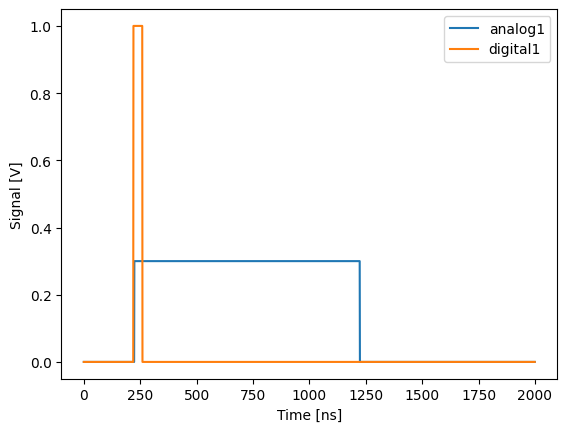

In [50]:
simulated_job = qmm.simulate(config_myfirst, program_myfirst, SimulationConfig(duration=int(2e3/4)))
# get DAC and digital samples
samples = simulated_job.get_simulated_samples()

# plot all ports:
plt.figure()
plt.plot(samples.con1.analog["1"], "-", label='analog1')
plt.plot(samples.con1.digital["1"], "-", label='digital1')
plt.legend()
plt.xlabel("Time [ns]")
plt.ylabel("Signal [V]")        
plt.show()

In [ ]:
qm = qmm.open_qm(config_myfirst)
job = qm.execute(program_myfirst)

Now let's play more complicated pulses.\
We add to the previous configuration dictionary new entries in operations, pulses, waveforms.
- gaussian pulse
- sinusoidal with gaussian modulation

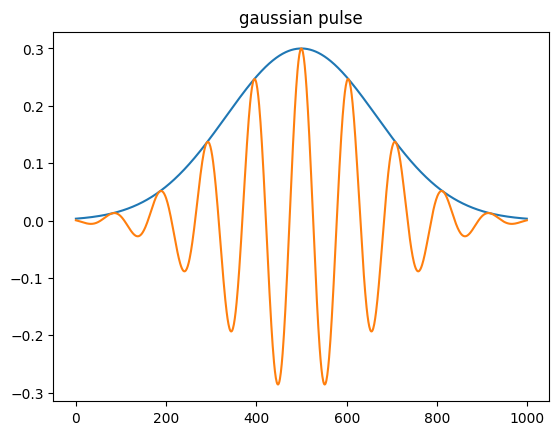

In [4]:
# gaussian waveform
sampling_rate = 1e9 #Samples/s
gaus_pulse_duration = 1e-6 # s
gaus_pulse_len = sampling_rate*gaus_pulse_duration # number of samples. Corresponds to the pulse duration IF the sampling rate is 1 ns (default)
gaus_amp = 0.3 # Volts
gaus_arg = np.linspace(-3, 3, int(gaus_pulse_len)) # here we define the sampling range
gaus_wf = np.exp(-gaus_arg**2/2)
gaus_wf = gaus_amp * gaus_wf/np.max(gaus_wf)

# sinusoidal waveform with gaussian envelope
cos_gaus_wf = np.cos(10*gaus_arg) * gaus_wf

plt.plot(gaus_wf)
plt.plot(cos_gaus_wf)
plt.title('gaussian pulse')

config_gaus = config_myfirst

gaus_operations = {'gaussian':'gaussian_pulse',
                   'cos_gaussian':'cos_gaussian_pulse'}
gaus_pulse = {'gaussian_pulse' : {'operation':'control', 
                                  'length':int(gaus_pulse_len), 
                                  'waveforms':{'single':'gaussian_wf'}},
            'cos_gaussian_pulse' : {'operation':'control', 
                                  'length':int(gaus_pulse_len), 
                                  'waveforms':{'single':'cos_gaussian_wf'}}}
gaus_waveform = {'gaussian_wf' : {'type':'arbitrary', 
                                  'samples':gaus_wf, 
                                  'sampling_rate':int(sampling_rate)},
                'cos_gaussian_wf' : {'type':'arbitrary', 
                                  'samples':cos_gaus_wf, 
                                  'sampling_rate':int(sampling_rate)}}

config_gaus['elements']['channel1']['operations'].update(gaus_operations)
config_gaus['pulses'].update(gaus_pulse)
config_gaus['waveforms'].update(gaus_waveform)

In [5]:
config_gaus

{'version': 1,
 'controllers': {'con1': {'type': 'opx1',
   'analog_outputs': {1: {'offset': 0.0, 'delay': 0},
    2: {'offset': 0.0, 'delay': 0},
    3: {'offset': 0.0, 'delay': 0}},
   'digital_outputs': {1: {}}}},
 'elements': {'channel1': {'operations': {'high': 'high_pulse',
    'low': 'low_pulse',
    'gaussian': 'gaussian_pulse',
    'cos_gaussian': 'cos_gaussian_pulse'},
   'singleInput': {'port': ('con1', 1)},
   'digitalInputs': {'output_switch': {'port': ('con1', 1),
     'delay': 0,
     'buffer': 0}}},
  'trigger3': {'operations': {'trigger': 'trigger_pulse'},
   'singleInput': {'port': ('con1', 3)}}},
 'pulses': {'high_pulse': {'operation': 'control',
   'length': 1000.0,
   'waveforms': {'single': 'const_wf'},
   'digital_marker': 'marker1'},
  'low_pulse': {'operation': 'control',
   'length': 1000.0,
   'waveforms': {'single': 'zero_wf'}},
  'trigger_pulse': {'operation': 'control',
   'length': 100,
   'waveforms': {'single': 'trigger_wf'}},
  'gaussian_pulse': {'oper

2024-12-17 22:45:49,925 - qm - INFO     - Simulating program


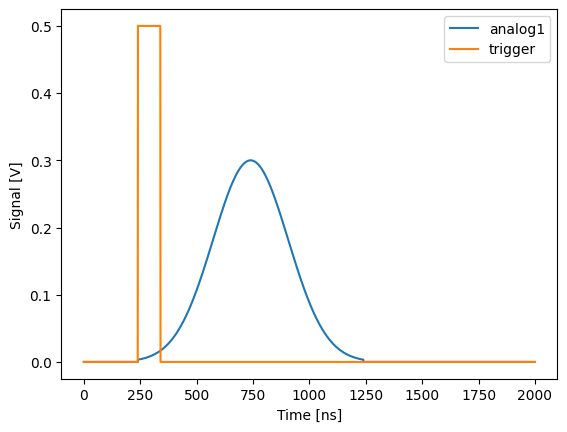

In [53]:
with program() as program_gaus:
    with infinite_loop_():
        play('trigger','trigger3')
        play('gaussian','channel1')
        play('low','channel1')

simulated_job = qmm.simulate(config_gaus, program_gaus, SimulationConfig(duration=int(2e3/4)))
# get DAC and digital samples
samples = simulated_job.get_simulated_samples()

# plot all ports:
plt.figure()
plt.plot(samples.con1.analog["1"], "-", label='analog1')
plt.plot(samples.con1.analog["3"], "-", label='trigger')
plt.legend()
plt.xlabel("Time [ns]")
plt.ylabel("Signal [V]")        
plt.show()

In [ ]:
qm = qmm.open_qm(config_gaus)
job = qm.execute(program_gaus)

2024-12-17 22:45:57,348 - qm - INFO     - Simulating program


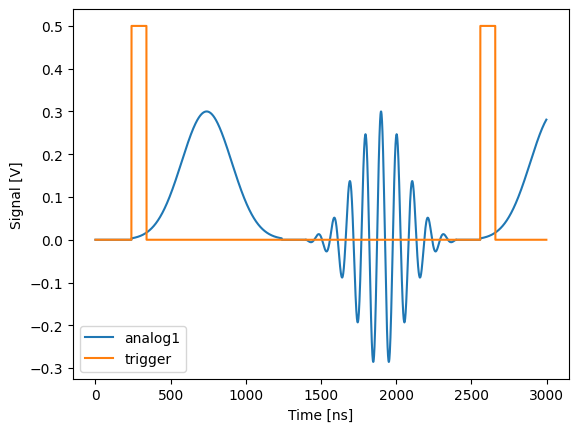

In [54]:
with program() as program_gaus2:
    with infinite_loop_():
        play('trigger','trigger3')
        play('gaussian','channel1')
        play('low','channel1', duration=40)
        play('cos_gaussian','channel1')
        play('low','channel1', duration=40)

simulated_job = qmm.simulate(config_gaus, program_gaus2, SimulationConfig(duration=int(3e3/4)))
# get DAC and digital samples
samples = simulated_job.get_simulated_samples()

# plot all ports:
plt.figure()
plt.plot(samples.con1.analog["1"], "-", label='analog1')
plt.plot(samples.con1.analog["3"], "-", label='trigger')
plt.legend()
plt.xlabel("Time [ns]")
plt.ylabel("Signal [V]")        
plt.show()


In [ ]:
job = qm.execute(program_gaus2)

#### Synchronization and multiple channels
If we add a second channel, we can control the synchronization between the two elements.

In [9]:
# add a new channel 2
config_multiple = deepcopy(config_gaus)
config_multiple
#add_channel = {'channel2': {'operations':{'high': 'high_pulse',
#                                        'low': 'low_pulse',
#                                        'gaussian': 'gaussian_pulse',
#                                        'cos_gaussian': 'cos_gaussian_pulse'}},
#                            'singleInput': {'port': ('con1', 2)}}

add_channel = {'channel2': {'operations': {'high': 'high_pulse',
                                            'low': 'low_pulse',
                                            'gaussian': 'gaussian_pulse',
                                            'cos_gaussian': 'cos_gaussian_pulse'},
                            'singleInput': {'port': ('con1', 2)}}}
config_multiple['elements'].update(add_channel)
config_multiple

{'version': 1,
 'controllers': {'con1': {'type': 'opx1',
   'analog_outputs': {1: {'offset': 0.0, 'delay': 0},
    2: {'offset': 0.0, 'delay': 0},
    3: {'offset': 0.0, 'delay': 0}},
   'digital_outputs': {1: {}}}},
 'elements': {'channel1': {'operations': {'high': 'high_pulse',
    'low': 'low_pulse',
    'gaussian': 'gaussian_pulse',
    'cos_gaussian': 'cos_gaussian_pulse'},
   'singleInput': {'port': ('con1', 1)},
   'digitalInputs': {'output_switch': {'port': ('con1', 1),
     'delay': 0,
     'buffer': 0}}},
  'trigger3': {'operations': {'trigger': 'trigger_pulse'},
   'singleInput': {'port': ('con1', 3)}},
  'channel2': {'operations': {'high': 'high_pulse',
    'low': 'low_pulse',
    'gaussian': 'gaussian_pulse',
    'cos_gaussian': 'cos_gaussian_pulse'},
   'singleInput': {'port': ('con1', 2)}}},
 'pulses': {'high_pulse': {'operation': 'control',
   'length': 1000.0,
   'waveforms': {'single': 'const_wf'},
   'digital_marker': 'marker1'},
  'low_pulse': {'operation': 'control

In [10]:
config_multiple['elements']['channel1']

{'operations': {'high': 'high_pulse',
  'low': 'low_pulse',
  'gaussian': 'gaussian_pulse',
  'cos_gaussian': 'cos_gaussian_pulse'},
 'singleInput': {'port': ('con1', 1)},
 'digitalInputs': {'output_switch': {'port': ('con1', 1),
   'delay': 0,
   'buffer': 0}}}

In [12]:
config_multiple['elements']['channel2']

{'operations': {'high': 'high_pulse',
  'low': 'low_pulse',
  'gaussian': 'gaussian_pulse',
  'cos_gaussian': 'cos_gaussian_pulse'},
 'singleInput': {'port': ('con1', 2)}}

2024-12-18 09:55:14,777 - qm - INFO     - Simulating program


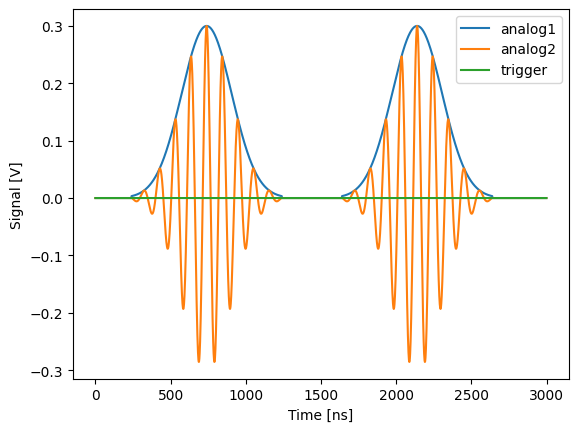

In [ ]:
# play for two channels
# without the alignment
with program() as multiple_channels:
    with infinite_loop_():
        play('gaussian', 'channel1')
        play('cos_gaussian', 'channel2')
        wait(100, 'channel1','channel2')

simulated_job = qmm.simulate(config_multiple, multiple_channels, SimulationConfig(duration=int(3e3/4)))
# get DAC and digital samples
samples = simulated_job.get_simulated_samples()

# plot all ports:
plt.figure()
plt.plot(samples.con1.analog["1"], "-", label='analog1')
plt.plot(samples.con1.analog["2"], "-", label='analog2')
plt.plot(samples.con1.analog["3"], "--", label='trigger')
plt.legend()
plt.xlabel("Time [ns]")
plt.ylabel("Signal [V]")        
plt.show()

In [ ]:
qm = qmm.open_qm(config_multiple)
job = qm.execute(multiple_channels)

2024-12-18 09:56:20,851 - qm - INFO     - Simulating program


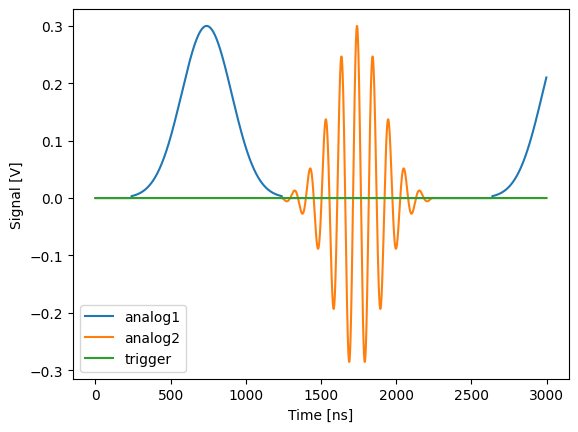

In [15]:
# with the alignment
with program() as multiple_channels_align:
        with infinite_loop_():
            play('gaussian', 'channel1')
            align('channel1','channel2')
            play('cos_gaussian', 'channel2')
            wait(100, 'channel1','channel2')

simulated_job = qmm.simulate(config_multiple, multiple_channels_align, SimulationConfig(duration=int(3e3/4)))
# get DAC and digital samples
samples = simulated_job.get_simulated_samples()

# plot all ports:
plt.figure()
plt.plot(samples.con1.analog["1"], "-", label='analog1')
plt.plot(samples.con1.analog["2"], "-", label='analog2')
plt.plot(samples.con1.analog["3"], "-", label='trigger')
plt.legend()
plt.xlabel("Time [ns]")
plt.ylabel("Signal [V]")        
plt.show()

In [ ]:
qm = qmm.open_qm(config_multiple)
job = qm.execute(multiple_channels_align)

#### Control flow statements
The paradigm of the OPX hardware is to use its programming language (QUA) for high synchronization, and avoid storing too much in memory for repetitive pulses. Suppose we want to play the same pulse 1´000 times...

2024-12-17 22:11:12,410 - qm - INFO     - Simulating program


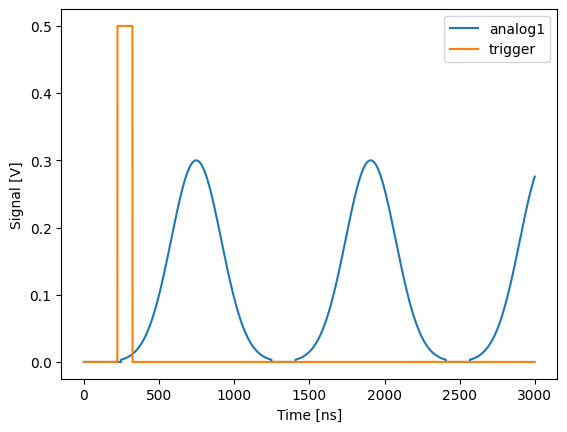

In [12]:
with program() as repeat_gaus:
    n = declare(int, value=0)

    play('trigger','trigger3')
    with for_(n, 0, 1000, n+1):
        play('gaussian','channel1')
        play('low','channel1', duration=40)

simulated_job = qmm.simulate(config_gaus, repeat_gaus, SimulationConfig(duration=int(3e3/4)))
# get DAC and digital samples
samples = simulated_job.get_simulated_samples()

# plot all ports:
plt.figure()
plt.plot(samples.con1.analog["1"], "-", label='analog1')
plt.plot(samples.con1.analog["3"], "-", label='trigger')
plt.legend()
plt.xlabel("Time [ns]")
plt.ylabel("Signal [V]")        
plt.show()

In [ ]:
qm = qmm.open_qm(config_gaus)
job = qm.execute(repeat_gaus)

#### Real time computations
We can "dynamically" change the amplitude and time of the pulses without storing them in memory. It is recommended to limit this use only when strictly needed, because it can introduce some time gaps. If possible, declare different pulses with different durations.

2024-12-17 22:29:26,626 - qm - INFO     - Simulating program


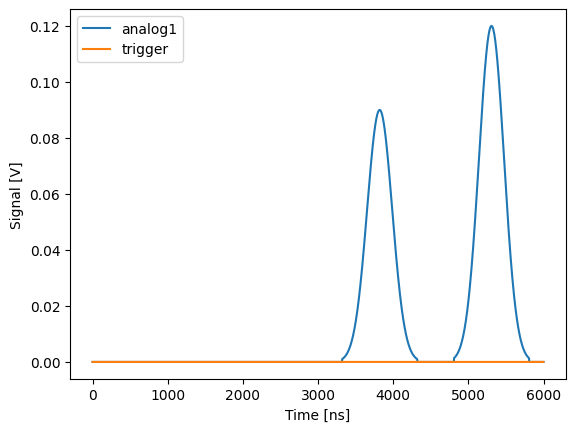

In [ ]:
with program() as amplitude_modulation:
    a = declare(fixed)
    with infinite_loop_():
        with for_(a, 0.1, a < 0.5, a + 0.05):
                    play('gaussian'*amp(a), 'channel1')
                    #play('gaussian'*amp(a), 'channel1', condition=(Math.sin(a)>0.2))
                    wait(100, 'channel1')
                    
simulated_job = qmm.simulate(config_gaus, amplitude_modulation, SimulationConfig(duration=int(6e3/4)))
# get DAC and digital samples
samples = simulated_job.get_simulated_samples()

# plot all ports:
plt.figure()
plt.plot(samples.con1.analog["1"], "-", label='analog1')
plt.plot(samples.con1.analog["3"], "-", label='trigger')
plt.legend()
plt.xlabel("Time [ns]")
plt.ylabel("Signal [V]")        
plt.show()

In [ ]:
qm = qmm.open_qm(config_gaus)
job = qm.execute(amplitude_modulation)

#### What's missing?
More advanced concepts
- streams
- "measurement" pulses (ADC)
- IQ mixing 
- ...

Refer to the offical documentation: https://docs.quantum-machines.co/latest/ \
Github repository with tutorials: https://github.com/qua-platform/qua-libs \
Github repository with some macros: https://github.com/qua-platform/py-qua-tools
